### For pre-processing of MPRA barcode counts and preliminary QCs

In [1]:
import os
import sys
import glob2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import plotly.express as px

In [4]:
os.getcwd()

'/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/CRXHD_mpra_GitHubSubmission/hdmuts_retina_analysis/scripts'

In [2]:
# set up directories
scriptdir=os.path.join(os.getcwd(), "utils")
sys.path.insert(0, scriptdir)

outbase_dir = os.path.split(os.getcwd())[0]

In [5]:
sys.path

['/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/CRXHD_mpra_GitHubSubmission/hdmuts_retina_analysis/scripts/utils',
 '/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/CRXHD_mpra_GitHubSubmission/hdmuts_retina_analysis/scripts',
 '/home/qiaoerrrrr/miniconda3/envs/mpra/lib/python39.zip',
 '/home/qiaoerrrrr/miniconda3/envs/mpra/lib/python3.9',
 '/home/qiaoerrrrr/miniconda3/envs/mpra/lib/python3.9/lib-dynload',
 '',
 '/home/qiaoerrrrr/miniconda3/envs/mpra/lib/python3.9/site-packages',
 '../../']

In [7]:
from utils import mpra_plot_utils, specseq_plot_utils, mpra_qc_normalization
specseq_plot_utils.set_manuscript_params()

### I. fastq to barcode counts (can also run in a separate sbatch script demux_and_BCcount.sbatch)

In [27]:
demux_count_script = os.path.join(scriptdir, "demultiplexAndBarcodeCount.sh")
fastqToSample = os.path.join(outbase_dir, "annotations", "fastq_meta.tsv")
p1_to_sample = os.path.join(outbase_dir, "annotations", "030523_p1Index_lookup.tsv")
spacerSeq="CACCTGTTCCTGTAGGCATGC"
bcSize=10

In [13]:
!bash ../scripts/utils/demultiplexAndBarcodeCount.sh "{fastqToSample}" "{spacerSeq}" "{bcSize}" "{scriptdir}"
## remember to change delimiter in the py script, MacOS only works with ",", LinuxOS works fine with "\t"
# Note: if run in JupyterLab on htcf server, need to specify full directory in fastq_meta.tsv

/scratch/sclab/030523_MPRA/raw_fq/HL7M7DSX5_CCACTCTCGT-TTATCGTTAT_L001_R1.fastq.gz dna /scratch/sclab/030523_MPRA/030523_p1Index_lookup.tsv /scratch/sclab/030523_MPRA/full_library.fimo0.0025.annotations.tsv /scratch/sclab/030523_MPRA/counts
input fastq:  /scratch/sclab/030523_MPRA/raw_fq/HL7M7DSX5_CCACTCTCGT-TTATCGTTAT_L001_R1.fastq.gz
sample name:  dna
fastq to sample mapping: /scratch/sclab/030523_MPRA/030523_p1Index_lookup.tsv
BC annotation file:   /scratch/sclab/030523_MPRA/full_library.fimo0.0025.annotations.tsv
output direcotry: /scratch/sclab/030523_MPRA/counts
Demultiplexing dna
[2023-03-05 15:07:35][INFO   ] Demultiplexed 1.0 million reads
[2023-03-05 15:07:49][INFO   ] Demultiplexed 2.0 million reads
[2023-03-05 15:08:03][INFO   ] Demultiplexed 3.0 million reads
[2023-03-05 15:08:17][INFO   ] Demultiplexed 4.0 million reads
[2023-03-05 15:08:32][INFO   ] Demultiplexed 5.0 million reads
[2023-03-05 15:08:47][INFO   ] Demultiplexed 6.0 million reads
[2023-03-05 15:09:07][INFO  

#### compile all count matricex into single dataframe

In [8]:
# first read in the annotation file so that have a map for all sequences
full_library_df = pd.read_csv(os.path.join(outbase_dir, "annotations", "full_library.fimo0.0025.tsv"), sep="\t", header=0)
# make a copy
full_compiled_df = full_library_df.copy()

# list all count matrix in folder "counts"
all_count_matrix = glob2.glob(os.path.join(outbase_dir,"counts","*.counts.tsv"))

for f in all_count_matrix:
    name = os.path.split(f)[1].split(".")[0]

    c_df = pd.read_csv(f, sep="\t", index_col="barcode").drop(columns="label").rename(columns={"count": name})

    full_compiled_df = pd.merge(full_compiled_df, c_df, how="inner", left_on="BC", right_on="barcode")

In [9]:
full_compiled_df.columns

Index(['seqnames', 'start', 'end', 'peak.id', 'annotation', 'motif', 'BC',
       'label', 'fullOligo', 'CRE', 'BC.inOligo', 'dnaehet', 'dnaehom',
       'dnakhet', 'dnakhom', 'dnarhom', 'dnawt', 'rna1ehet', 'rna1ehom',
       'rna1khet', 'rna1khom', 'rna1rhom', 'rna1wt', 'rna2ehet', 'rna2ehom',
       'rna2khet', 'rna2khom', 'rna2rhom', 'rna2wt', 'rna3ehet', 'rna3ehom',
       'rna3khet', 'rna3khom', 'rna3rhom', 'rna3wt', 'rna4ehet', 'rna4ehom',
       'rna4khet', 'rna4khom', 'rna4rhom', 'rna4wt'],
      dtype='object')

In [21]:
# save compiled count matrix
full_compiled_df.to_csv(os.path.join(outbase_dir, "compiled_counts", f"030523_dna_rna_compiled.counts.tsv"), sep="\t", float_format="%d", index=False)

In [57]:
plasmid_df = pd.read_csv(os.path.join(outbase_dir, "compiled_counts", "101222_plasmid_compiled.counts.tsv"), sep="\t", header=0, index_col="barcode")
plasmid_df["plasmid.avg"] = (plasmid_df["libE"]+plasmid_df["libF"])/2
plasmid_df = plasmid_df.rename(columns={"libE":"plasmid.libE","libF":"plasmid.libF"})

In [59]:
compiled_count_matrix = pd.merge(full_compiled_df, plasmid_df, on="label", how="left").rename(columns={"BC":"barcode"})

In [60]:
compiled_count_matrix.head()

,seqnames,start,end,peak.id,annotation,motif,barcode,label,fullOligo,CRE,...,rna3wt,rna4ehet,rna4ehom,rna4khet,rna4khom,rna4rhom,rna4wt,plasmid.libE,plasmid.libF,plasmid.avg
0,chr1,4360266.0,4360399.0,peak.3,RetinalGene,WT,TTGATCCTAC,chr1-4360266-4360399_peak.3_RetinalGene_WT_TTG...,GTAGCGTCTGTCCGTGAATTCGGATATGCAACCTGCTTGTTTCACG...,GGATATGCAACCTGCTTGTTTCACGTAAACAAATGTCTTTGGATTT...,...,6949,0,7610,3900,2339,0,6000,2899,3451,3175.0
1,chr1,4360266.0,4360399.0,peak.3,RetinalGene,WT,GTCACAACAA,chr1-4360266-4360399_peak.3_RetinalGene_WT_GTC...,GTAGCGTCTGTCCGTGAATTCGGATATGCAACCTGCTTGTTTCACG...,GGATATGCAACCTGCTTGTTTCACGTAAACAAATGTCTTTGGATTT...,...,7970,0,6903,4342,2313,0,7818,3459,4178,3818.5
2,chr1,4360266.0,4360399.0,peak.3,RetinalGene,WT,TAACAGGTGG,chr1-4360266-4360399_peak.3_RetinalGene_WT_TAA...,GTAGCGTCTGTCCGTGAATTCGGATATGCAACCTGCTTGTTTCACG...,GGATATGCAACCTGCTTGTTTCACGTAAACAAATGTCTTTGGATTT...,...,526,0,520,228,251,0,438,402,281,341.5
3,chr1,4360266.0,4360399.0,peak.3,RetinalGene,WT,GAGCGCGATG,chr1-4360266-4360399_peak.3_RetinalGene_WT_GAG...,GTAGCGTCTGTCCGTGAATTCGGATATGCAACCTGCTTGTTTCACG...,GGATATGCAACCTGCTTGTTTCACGTAAACAAATGTCTTTGGATTT...,...,2553,0,3012,1223,970,0,3247,2108,1944,2026.0
4,chr1,4360266.0,4360399.0,peak.3,RetinalGene,mutM,GTTGAGGCCA,chr1-4360266-4360399_peak.3_RetinalGene_mutM_G...,GTAGCGTCTGTCCGTGAATTCGGATATGCAACCTGCTTGTTTCACG...,GGATATGCAACCTGCTTGTTTCACGTAAACAAATGTCTTTGGATTT...,...,612,0,985,549,707,0,520,3058,3226,3142.0


In [51]:
compiled_count_matrix.to_csv(os.path.join(outbase_dir, "compiled_counts", f"030523_dna_rna_plasmid_compiled.counts.tsv"), sep="\t", float_format="%d", index=False)

#### assess replicate reproducibility - RNA samples

In [ ]:
for geno in ["wt", "ehet", "ehom", "khet", "khom", "rhom"]:
    rep1_df = pd.read_csv(os.path.join(outbase_dir, "counts", f"rna1{geno}.counts.tsv"), sep="\t", index_col="barcode")
    rep2_df = pd.read_csv(os.path.join(outbase_dir, "counts", f"rna2{geno}.counts.tsv"), sep="\t", index_col="barcode")
    rep3_df = pd.read_csv(os.path.join(outbase_dir, "counts", f"rna3{geno}.counts.tsv"), sep="\t", index_col="barcode")
    dna_df = pd.read_csv(os.path.join(outbase_dir, "counts", f"dna{geno}.counts.tsv"), sep="\t", index_col="barcode")

    fig, ax_list = plt.subplots(nrows=3, ncols=3, figsize=(8,8), dpi=150, )

    ax_list[0,0] = mpra_plot_util._using_plain_scatter(rep2_df["count"], rep1_df["count"], f"rna2{geno}", f"rna1{geno}", useLog=True, ax=ax_list[0,0])
    ax_list[0,1] = mpra_plot_util._using_plain_scatter(rep3_df["count"], rep1_df["count"], f"rna3{geno}", f"rna1{geno}", useLog=True, ax=ax_list[0,1])
    ax_list[0,2] = mpra_plot_util._using_plain_scatter(dna_df["count"], rep1_df["count"], f"dna{geno}", f"rna1{geno}", useLog=True, ax=ax_list[0,2])
    ax_list[1,0] = mpra_plot_util._using_plain_scatter(rep3_df["count"], rep2_df["count"], f"rna3{geno}", f"rna2{geno}", useLog=True, ax=ax_list[1,0])
    ax_list[1,1] = mpra_plot_util._using_plain_scatter(dna_df["count"], rep2_df["count"], f"dna{geno}", f"rna2{geno}", useLog=True, ax=ax_list[1,1])
    ax_list[2,0] = mpra_plot_util._using_plain_scatter(dna_df["count"], rep3_df["count"], f"dna{geno}", f"rna3{geno}", useLog=True, ax=ax_list[2,0])


    if geno in ["ehet", "rhom"]:
        [ax.remove() for ax in [ax_list[1,2],ax_list[2,1],ax_list[2,2]]]
    else:
        rep4_df = pd.read_csv(os.path.join(outbase_dir, "counts", f"rna4{geno}.counts.tsv"), sep="\t", index_col="barcode")
        ax_list[1,2] = mpra_plot_util._using_plain_scatter(rep4_df["count"], rep1_df["count"], f"rna4{geno}", f"rna1{geno}", useLog=True, ax=ax_list[1,2])
        ax_list[2,1] = mpra_plot_util._using_plain_scatter(rep4_df["count"], rep2_df["count"], f"rna4{geno}", f"rna2{geno}", useLog=True, ax=ax_list[2,1])
        ax_list[2,2] = mpra_plot_util._using_plain_scatter(rep4_df["count"], rep3_df["count"], f"rna4{geno}", f"rna3{geno}", useLog=True, ax=ax_list[2,2])
    
    fig.tight_layout()

    figname = os.path.join(outbase_dir, "figures", "rep_corr_scatter_raw",f"{geno}_repcorrScatter")

    # save figure
    plt.close()
    fig.savefig(f"{figname}.svg")
    fig.savefig(f"{figname}.png")

#### check dna correlation with plasmid

In [ ]:
dna_count_df_Ser = {}
for geno in ["wt", "ehet", "ehom", "khet", "khom", "rhom"]:
    dna_count_df_Ser[geno] = pd.read_csv(os.path.join(outbase_dir,dna_count_df_Ser "counts", f"dna{geno}.counts.tsv"), sep="\t", index_col="barcode")
dna_count_df_Ser = pd.Series(dna_count_df_Ser)

('r = 0.970', 'ρ = 0.984', 0.5516208374404854, -155.73076953024247)
('r = 0.958', 'ρ = 0.978', 0.6363657915049782, -210.30422447663682)
('r = 0.962', 'ρ = 0.979', 0.6373868772922542, -184.29317451325824)
('r = 0.952', 'ρ = 0.975', 0.6680458292052416, -181.80086944447294)
('r = 0.957', 'ρ = 0.970', 0.5698259964471055, -37.404762998728074)
('r = 0.935', 'ρ = 0.972', 0.6761170270169368, -211.25721766271613)


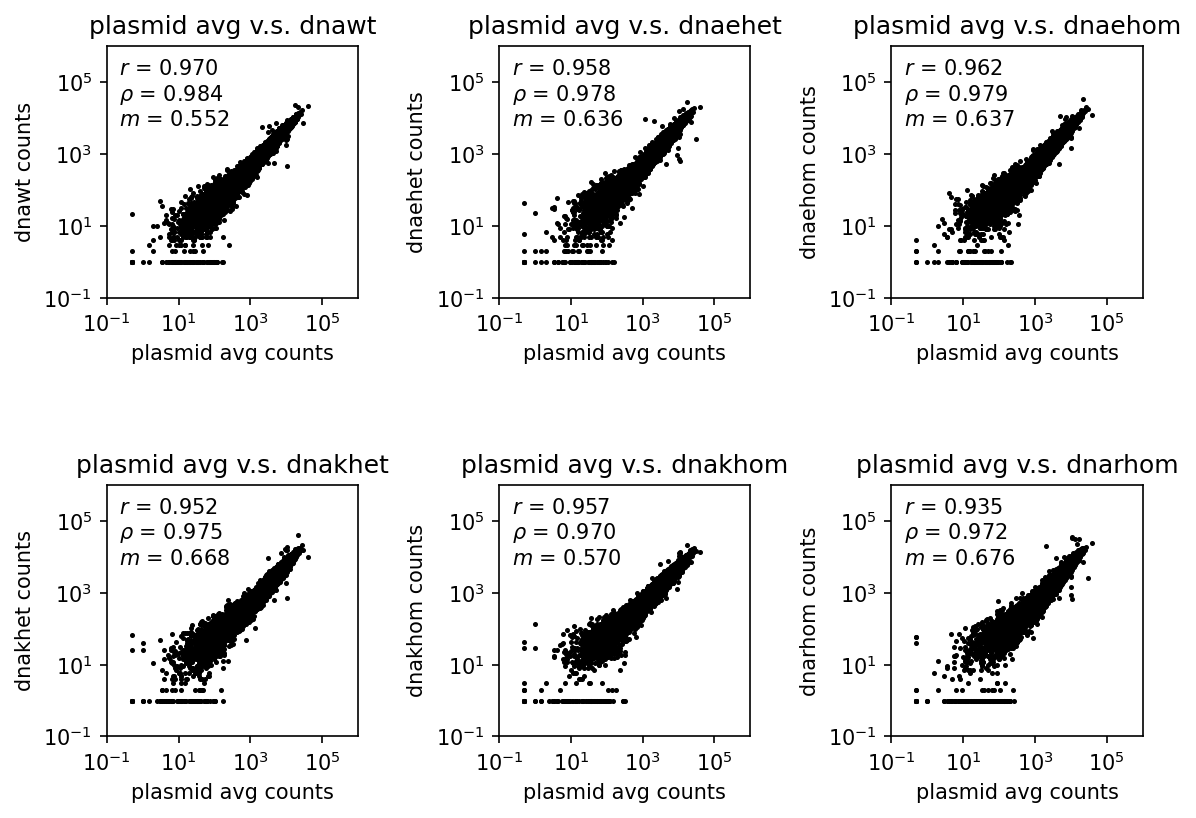

In [77]:
fig, ax_list = plt.subplots(nrows=2, ncols=3, figsize=(8,6), dpi=150, )
ax_list = ax_list.flatten()

for i, ax in enumerate(ax_list):
    geno = dna_count_df_Ser.index[i]
    ax_list[i] = mpra_plot_util._using_plain_scatter(plasmid_df["plasmid.avg"], dna_count_df_Ser[geno]["count"], f"plasmid avg", f"dna{geno}", useLog=True, ax=ax_list[i])

fig.tight_layout()

figname = os.path.join(outbase_dir, "figures", "rep_corr_scatter_raw",f"plasmid_dna_repcorrScatter")

In [78]:
fig.savefig(f"{figname}.svg")
fig.savefig(f"{figname}.png")

### III. basic filterings
#### split up the annotation columns so that it is eaiser to read

In [52]:
annot_df = compiled_count_matrix.loc[:,lambda df: ~(df.columns.str.contains("rna") | 
                                                    df.columns.str.contains("dna") |
                                                    df.columns.str.contains("plasmid"))].copy()

# add a single column to identify CRE without BC
annot_df["annots"] = annot_df.label.apply(lambda text: text[:-11])
# and generate a lookup dataframe for all designed barcodes
design_barcodes = annot_df.reset_index(drop=False)[["barcode","annotation","motif"]].groupby(["annotation","motif"]).count().rename(columns={"barcode":"design"})

In [53]:
annot_df.to_csv(os.path.join(outbase_dir, "compiled_counts", "hdmuts_full_annot.tsv"), sep="\t", index=False, header=True)

#### i. drop BCs if plasmid pool <= 50 counts

In [54]:
# identify BCs with less than 50 counts in the plasmid library
plasmid_lowCount_mask = compiled_count_matrix.loc[:,["plasmid.libE","plasmid.libF"]].applymap(lambda x: x>=50).sum(axis=1)
# display the low count BCs
print("BCs with lower than 50 counts in either plasmid library: "+str(sum(plasmid_lowCount_mask==0)))

BCs with lower than 50 counts in either plasmid library: 1089


In [30]:
# just to be sure, check what catergories are these low count BCs
plasmid_lowCount_annot = annot_df.loc[plasmid_lowCount_mask==0,:].copy()
plasmid_lowCount_badcodes_byCategory = mpra_qc_normalization.fraction_by_category(query_BC=plasmid_lowCount_annot, ref_df=annot_df, col_name="dropped")
display(plasmid_lowCount_badcodes_byCategory)

design  dropped  fc.dropped
annotation  motif                                 
EGain       WT            808       15    0.018564
            mutM          772        5    0.006477
ELost       WT           1128       65    0.057624
            mutD          436       16    0.036697
            mutDM         352       11    0.031250
            mutM          932       32    0.034335
KGain       WT           1648      324    0.196602
            mutD         1036      150    0.144788
            mutDM         956       98    0.102510
            mutM         1536      201    0.130859
            scrambled      12        1    0.083333
KLost       WT           1948       26    0.013347
            mutD          256       11    0.042969
            mutDM         216        6    0.027778
            mutM         1660       15    0.009036
            scrambled     332        5    0.015060
NotDB       WT           1440       52    0.036111
            mutD          164       13    0.079268
            mutDM         156        2    0.012821
            mutM         1304       28    0.021472
            scrambled     236       10    0.042373
RetinalGene WT            176        2    0.011364
            mutM          156        1    0.006410

In [31]:
plasmid_lowCount_badcodes_byCategory.to_csv(os.path.join(outbase_dir, "compiled_counts", "030523_plasmid_lowCountCategoricalStats.tsv"), sep="\t", index=True)

In [32]:
# assess num of BCs dropped per CRE in those low count BCs
plasmid_lowCount_CREuniqueBC = plasmid_lowCount_annot.annots.value_counts()
plasmid_lowCount_CREuniqueBC.index.name = "count"
sum(plasmid_lowCount_CREuniqueBC>1)

329

In [33]:
# write to file
plasmid_lowCount_CREuniqueBC.to_csv(os.path.join(outbase_dir, "compiled_counts", "030523_plasmid_lowCountCREuniqueBCcounts.tsv"), sep="\t", index=True)

#### ii. drop CREs with less than 3 unique BCs recovered in plasmid samples

In [34]:
plasmid_uniqueBC_index = plasmid_lowCount_CREuniqueBC[plasmid_lowCount_CREuniqueBC>1].index
plasmid_uniqueBC_index = annot_df.loc[annot_df.annots.isin(plasmid_uniqueBC_index)].index
len(plasmid_uniqueBC_index)

1316

In [35]:
# check if the annots indeed matched that of the unique barcode filtering
set(annot_df.loc[plasmid_uniqueBC_index,["annots"]].squeeze().unique())-set(plasmid_lowCount_CREuniqueBC[plasmid_lowCount_CREuniqueBC>1].index)

set()

In [77]:
# drop low plasmid count BCs in both plasmid and rna samples
plasmid_filtered = compiled_count_matrix.loc[plasmid_lowCount_mask!=0,["barcode","plasmid.libE","plasmid.libF"]].copy()
data_filtered = full_compiled_df.loc[plasmid_lowCount_mask!=0,:].copy()

In [78]:
plasmid_filtered.to_csv(os.path.join(outbase_dir, "compiled_counts", "030523_plasmid_filteredBCcounts.tsv"), sep="\t", index=False, header=True)
data_filtered.to_csv(os.path.join(outbase_dir, "compiled_counts", "030523_dna_rna_filteredBCcounts.tsv"), sep="\t", index=False, header=True)

In [70]:
mpra_qc_normalization.fraction_by_category(query_BC=annot_df.loc[plasmid_uniqueBC_index], ref_df=annot_df, col_name="filtered")

design  filtered  fc.filtered
annotation motif                                   
EGain      WT            808        16     0.019802
           mutM          772         4     0.005181
ELost      WT           1128        80     0.070922
           mutD          436        20     0.045872
           mutDM         352         8     0.022727
           mutM          932        36     0.038627
KGain      WT           1648       388     0.235437
           mutD         1036       184     0.177606
           mutDM         956       116     0.121339
           mutM         1536       256     0.166667
KLost      WT           1948        36     0.018480
           mutD          256        16     0.062500
           mutDM         216         8     0.037037
           mutM         1660        16     0.009639
           scrambled     332         8     0.024096
NotDB      WT           1440        60     0.041667
           mutD          164        16     0.097561
           mutDM         156         4     0.025641
           mutM         1304        32     0.024540
           scrambled     236        12     0.050847

#### extract the rna samples for median read depth normalization by DEseq2

In [ ]:
data_for_DESeq2 = data_filtered.loc[:,lambda df: df.columns[df.columns.str.contains("rna")]]
# to avg across CRE, need to attach annotation table
data_for_DESeq2 = pd.merge(annot_df["annots"], data_for_DESeq2, left_index=True, right_index=True, how="inner")
# also drop those CREs with less than 3 unique BCs passing plasmid filter
data_for_DESeq2 = data_for_DESeq2.loc[list(set(data_for_DESeq2.index)-set(plasmid_uniqueBC_index)),:]
# and change all the basal annots to a simple "annots" for average
data_for_DESeq2.loc[data_for_DESeq2.annots.str.contains("basal"),"annots"]="basal"
# then get the CRE mean, round and convert to integer
data_for_DESeq2 = data_for_DESeq2.groupby("annots").mean().round().astype(int)

In [ ]:
# write to file
data_for_DESeq2.to_csv(os.path.join(outbase_dir, "compiled_counts", "030523_rna_compile_avg_count.tsv"), sep="\t", index=True, header=True)